In [1]:
import pandas as pd
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
PARQUET_PATH = "../../04_merged/all_merged.parquet"

# Required fields 
TIME_KEYS   = ["donor", "year", ]
CLONE_KEYS  = ["v_gene", "j_gene", "cdr3_aa"]
NEEDED_COLS = CLONE_KEYS + TIME_KEYS + ["isotype"] +['cdr3_length'] + ['sequence','productive'] + ['replicate'] + ['v_mutation_count'] + ['v_mutation_count_aa']

# Memory filter
MEMORY_ISOTYPES = ["IgG1","IgG2","IgG3","IgG4","IgA1","IgA2",]

# Other params
CLONOTYPE_KEYS = ['v_gene', 'j_gene', 'cdr3_aa'] 

In [5]:
# Use lazy scan for scale
lf = pl.scan_parquet(PARQUET_PATH).select(NEEDED_COLS)

# filter on productive
lf = lf.filter(pl.col('productive'))

# Compute Clonotypes
lf = lf.with_columns(
    (pl.col('v_gene') + pl.lit('|') + pl.col('j_gene') + pl.lit('|') + pl.col('cdr3_aa')).alias('clonotype'))

# Group timepoints
lf = lf.with_columns(
    pl.when(pl.col('year').is_in(["2020", "2021"]))
    .then(pl.lit('Late'))
    .otherwise(pl.lit('Early'))
    .alias('timepoint')
)

# Count timepoints and donors per clonotype
lf = lf.with_columns(
    (pl.col('timepoint').n_unique().over('clonotype').alias('n_timepoints')),
    (pl.col('donor').n_unique().over('clonotype').alias('n_donors')),
)

# Add biological replicate info
bioreps = {1:1,2:2,3:3,4:4,5:5,6:6,7:1,8:2,9:3,10:4,11:5,12:6,13:1,14:2,15:3,16:4,17:5,18:6}
mini_df = pl.LazyFrame({"replicate":k,"biorep":v} for k,v in bioreps.items())
lf = lf.join(mini_df, on='replicate', how='full', )

In [6]:
# Collect data once
df = lf.collect()

#### IgG frequency

In [7]:
NEEDED = ["replicate", "n_timepoints", "clonotype", "isotype"]

lz_small = (
    df.lazy()
      .select([c for c in NEEDED if c in df.columns])
)

result = (
    lz_small
    .group_by(["replicate", "n_timepoints"])
    .agg(
        total = pl.col("clonotype").n_unique(),
        IgM   = pl.col("clonotype")
                 .filter(pl.col("isotype").str.starts_with("IgM"))
                 .n_unique(),
        IgG   = pl.col("clonotype")
                 .filter(pl.col("isotype").str.starts_with("IgG"))
                 .n_unique(),
    )
    .with_columns(
        IgM_freq = (pl.col("IgM") / pl.col("total")).fill_null(0.0),
        IgG_freq = (pl.col("IgG") / pl.col("total")).fill_null(0.0),
    )
    .select("replicate","n_timepoints","total","IgM","IgM_freq","IgG","IgG_freq")
)

In [8]:
r = result.collect()

In [9]:
np_freq = r.filter(pl.col('n_timepoints') == 1).select(['IgG_freq'])
p_freq = r.filter(pl.col('n_timepoints') == 2).select(['IgG_freq'])

In [10]:
data_dict = {'persistent': p_freq["IgG_freq"].to_list(), 'non-persistent': np_freq["IgG_freq"].to_list()}

In [11]:
color_dict={'persistent': 'red', 'non-persistent': 'grey'}

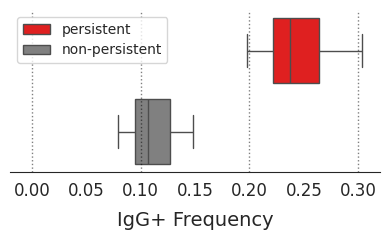

In [12]:
sns.set_style('white')
plt.figure(figsize=(4, 2.5))
ax = plt.gca()
sns.boxplot(data=data_dict,
            palette=['red','grey'],
             orient='h', ax=ax, legend=True, )
ax.set_xlim([-0.02, 0.32])
ax.set_xlabel('IgG+ Frequency', size=14, labelpad=8)
ax.tick_params(axis='x', which='major', labelsize=12)
ax.set_yticklabels("")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
for x in np.arange(0, 0.4, 0.1):
    ls = ':'
    lw = 1
    alpha=0.5
    plt.axvline(x=x, linewidth=lw, color='k', linestyle=ls, alpha=alpha)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('./2f_igg_frequency.svg', dpi=1200)
plt.show()
plt.close()

#### Mutations 

In [14]:
NEEDED = ["replicate", "n_timepoints", "v_mutation_count"]

lz_small = (
    df.lazy()
      .select([c for c in NEEDED if c in df.columns])
)

mut_stats = (
    lz_small
    .group_by(["replicate", "n_timepoints"])
    .agg(
        mut_median = pl.col("v_mutation_count").median(),
        mut_std    = pl.col("v_mutation_count").std(ddof=1),
        n = pl.len(),
    )
    .select("replicate","n_timepoints","mut_median","mut_std","n")
    .collect()
)

np_vals = (
    mut_stats
    .filter(pl.col("n_timepoints") == 1)
    .get_column("mut_median")
    .to_list()
)
p_vals = (
    mut_stats
    .filter(pl.col("n_timepoints") == 2)
    .get_column("mut_median")
    .to_list()
)

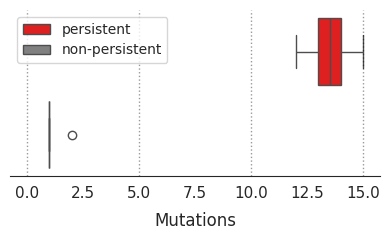

In [15]:
data_dict = {"persistent": p_vals, "non-persistent": np_vals}

sns.set_style('white')
plt.figure(figsize=(4, 2.5))
ax = plt.gca()
sns.boxplot(
    data=data_dict,
    palette=['red', 'grey'],
    orient='h',
    ax=ax, legend=True
)

ax.set_xlabel('Mutations', size=12, labelpad=8)
ax.set_ylabel('', size=0)
ax.tick_params(axis='x', labelsize=11)
ax.set_yticklabels("")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

for x in np.arange(0, max(p_vals + np_vals + [0]) * 1.1, 5):  # adjust step to your scale
    plt.axvline(x=x, linewidth=1, color='k', linestyle=':', alpha=0.4)

plt.tight_layout()
plt.legend(loc='upper left')
plt.savefig('./2g_v_mutation_count_box.svg', dpi=1200)
plt.show()
plt.close()

#### Freq of clonotypes in >1 bioreplicate

In [16]:
NEEDED = ["donor", "biorep", "clonotype", "n_timepoints"]
lz = (
    df.lazy()
      .select([c for c in NEEDED if c in df.columns])
)

per_clono_labels = (
    lz.group_by(["donor", "clonotype"])
      .agg(
          persistence = pl.col("n_timepoints").max(),
          n_reps_present = pl.col("biorep").n_unique(),
      )
)

present_rc = (
    lz.select("donor", "biorep", "clonotype").unique()
)

annot = (
    present_rc
    .join(per_clono_labels, on=["donor","clonotype"], how="inner")
)

per_rep_freq = (
    annot
    .group_by(["donor", "biorep", "persistence"])
    .agg(
        total = pl.len(),
        multi = (pl.col("n_reps_present") > 1).cast(pl.Int64).sum(),
    )
    .with_columns(freq = (pl.col("multi") / pl.col("total")).fill_null(0.0).cast(pl.Float64))
    .collect()
)

per_rep_plot = (
    per_rep_freq
    .with_columns(
        fraction = pl.when(pl.col("persistence")==2).then(pl.lit("persistent"))
                     .otherwise(pl.lit("non-persistent"))
    )
    .select("donor","biorep","fraction","freq")
)


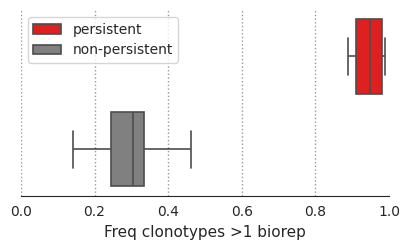

In [17]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(4.2, 2.6))
sns.boxplot(
    data=per_rep_plot.sort(pl.col('fraction'), descending=True).to_pandas(),
    x="freq", y="fraction", hue='fraction',
    palette=["red","grey"], orient="h", ax=ax, linewidth=1.2, 
)
ax.set_xlabel("Freq clonotypes >1 biorep", size=11)
ax.set_ylabel("")
ax.set_yticklabels("")
ax.set_xlim(0, 1)
ax.tick_params(axis="y", length=0)
for s in ("top","right","left"):
    ax.spines[s].set_visible(False)

for x in np.arange(0, 1, 0.2):
    plt.axvline(x=x, linewidth=1, color='k', linestyle=':', alpha=0.4)

plt.legend(labels=['persistent','non-persistent'], loc='upper left')
plt.tight_layout()
plt.savefig('./2h_freq_per_biorep.svg', dpi=1200)
plt.show()